In [8]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations
#files

NameError: name 'st_id_map' is not defined

In [2]:
?datetime.timedelta

Object `datetime.timedelta` not found.


In [3]:
# For just one fire, plot diurnal cycle with "spread days" vs "non-spread days"

## load up 
fireID = '6280' # Creek Fire
#fireID = '6360' # Bobcat fier 
#fireID = '4655' # William Flats
#fireID = '3956' # Cold Creek
gdf = fv.load_large_fire(fireID, year = "2020")

foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element

st_cls = fv.closest(st_dict, foi)

## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
gdf['t'] = gdf['t'].astype('datetime64[ns]')
gdf['t'] = gdf["t"] + datetime.timedelta(hours = 1, minutes= 30) ## Realign with sat passover times

gdf = gdf[gdf.t.dt.hour > 2] ### Only daytime hours

gdf["fline_diff"] = gdf.flinelen.diff() ## Add flireline difference for analysis later
gdf["farea_diff"] = gdf.farea.diff()

#gdf = gdf[gdf.t.astype("datetime64[ns]").hour > "00:00:00"]
#print(gdf.flinelen.diff() )

#print(gdf["fline_diff"].iloc[0:24])

full_fr = fv.fr_st_merge(gdf, st, sub = True)
#full_fr
#print(full_fr.fline_diff.iloc[0:24])

NameError: name 'fv' is not defined

In [4]:
#gdf.t
gdf

NameError: name 'gdf' is not defined

In [7]:
## Plot

# Define spread days vs non-spread days. Within 5% of largest spread = "non spread". Not exact at all
#print(max(full_fr["flinelen"]))

#spread_threshold = max(full_fr["flinelen"]) *0.50

#full_fr = full_fr[full_fr.t < '2019-08-15 12:00:00']


In [8]:
time_of_interest = 24
hours_before = 0

max_spread = max(full_fr.fline_diff[full_fr.fline_diff.notna()])
print(max_spread)
print(max_spread *0.15)



49.13220035802667
7.369830053704001


In [9]:
### Fire line difference
# full_fr["spread_line"] = ((full_fr["fline_diff"] > 0) & (full_fr["fline_diff"] > (max_spread * 0.15)))
# #full_fr["spread_line"] = ((full_fr["fline_diff"] > 0)) #& (full_fr["fline_diff"] > (max_spread * 0.15)))

# #full_fr["t_lag"] = full_fr["t"] - np.timedelta64(time_lag, 'h')
# times = full_fr["t"].loc[full_fr["spread_line"] ]
# #times_start = times - np.timedelta64(time_lag, "h")

# full_fr["sumFRP"] = full_fr.meanFRP * full_fr.n_newpixels

daytime = ['7','8','9','10','11','12','13','14','15','16','17','18'] # My def of daytime



full_fr["is_daytime"] = full_fr.HH.isin(daytime)
full_fr["flinlen_day"] = full_fr.flinelen

# mask = np.invert(full_fr.is_daytime)
# full_fr.flinlen_day.loc[mask] = np.nan
# #full_fr["flinlen_day_diff"] = 
# #full_fr.is_daytime.unique()

### Fire area differnce
full_fr["spread_line"] = ((full_fr["farea_diff"] > 0) & (full_fr["farea_diff"] > (max_spread * 0.50)))
#full_fr["spread_line"] = ((full_fr["fline_diff"] > 0)) #& (full_fr["fline_diff"] > (max_spread * 0.15)))

#full_fr["t_lag"] = full_fr["t"] - np.timedelta64(time_lag, 'h')
times = full_fr["t"].loc[full_fr["spread_line"] ]
times_not = full_fr["t"].loc[full_fr["spread_line"] == False]
times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]
print("TIMES:", times)
print("TIMES_NOT:", times_not)
#times_start = times - np.timedelta64(time_lag, "h")

full_fr["sumFRP"] = full_fr.meanFRP * full_fr.n_newpixels

full_fr["flinlen_day"] = full_fr.flinelen

mask = np.invert(full_fr.is_daytime)
full_fr.flinlen_day.loc[mask] = np.nan
#full_fr["flinlen_day_diff"] = 
#full_fr.is_daytime.unique()

TIMES: 1    2020-09-06 13:30:00
2    2020-09-07 13:30:00
3    2020-09-08 13:30:00
4    2020-09-09 13:30:00
5    2020-09-10 13:30:00
6    2020-09-11 13:30:00
8    2020-09-13 13:30:00
9    2020-09-14 13:30:00
11   2020-09-16 13:30:00
12   2020-09-17 13:30:00
14   2020-09-19 13:30:00
16   2020-09-21 13:30:00
30   2020-10-05 13:30:00
Name: t, dtype: datetime64[ns]
TIMES_NOT: 0    2020-09-05 13:30:00
7    2020-09-12 13:30:00
10   2020-09-15 13:30:00
13   2020-09-18 13:30:00
15   2020-09-20 13:30:00
17   2020-09-22 13:30:00
18   2020-09-23 13:30:00
19   2020-09-24 13:30:00
20   2020-09-25 13:30:00
21   2020-09-26 13:30:00
22   2020-09-27 13:30:00
23   2020-09-28 13:30:00
24   2020-09-29 13:30:00
25   2020-09-30 13:30:00
26   2020-10-01 13:30:00
27   2020-10-02 13:30:00
28   2020-10-03 13:30:00
29   2020-10-04 13:30:00
31   2020-10-06 13:30:00
32   2020-10-07 13:30:00
33   2020-10-08 13:30:00
34   2020-10-09 13:30:00
35   2020-10-10 13:30:00
36   2020-10-11 13:30:00
37   2020-10-12 13:30:00
3

/tmp/ipykernel_323/3030129942.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.flinlen_day.loc[mask] = np.nan


In [10]:
#print(times)
#print(times_start)

full_fr["spread_day"] = np.nan
for t in times:
    times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = t - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
    

for l in times_not:
    times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
    times_end = l - np.timedelta64((hours_before), "h")
    full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False
    
# full_fr["spread_day"] = False
# for t in times:
#     times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
#     times_end = t - np.timedelta64((hours_before), "h")
#     full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
full_fr["spread_day"]

/tmp/ipykernel_323/445970531.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr.spread_day[(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


0       False
1        True
2        True
3        True
4        True
        ...  
1396    False
1397    False
1398    False
1399    False
1400    False
Name: spread_day, Length: 1401, dtype: object

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'fline_diff',
       'farea_diff', 'YYYY', 'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA',
       'WDSPD_KPH', 'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI',
       'FWI', 'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format', 'is_daytime',
       'flinlen_day', 'spread_line', 'sumFRP', 'spread_day'],
      dtype='object')


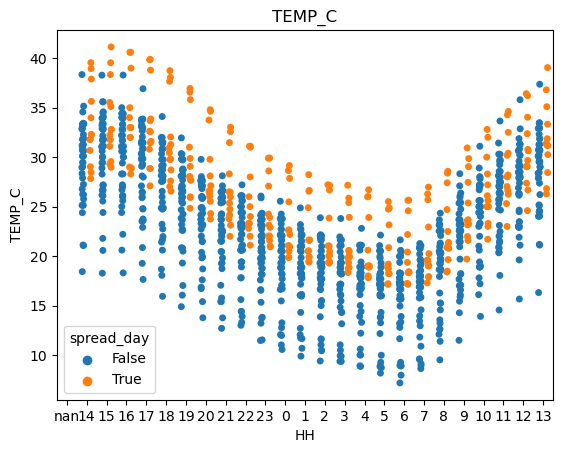

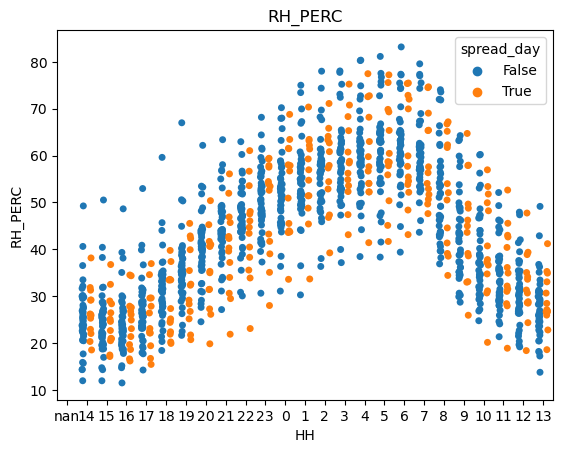

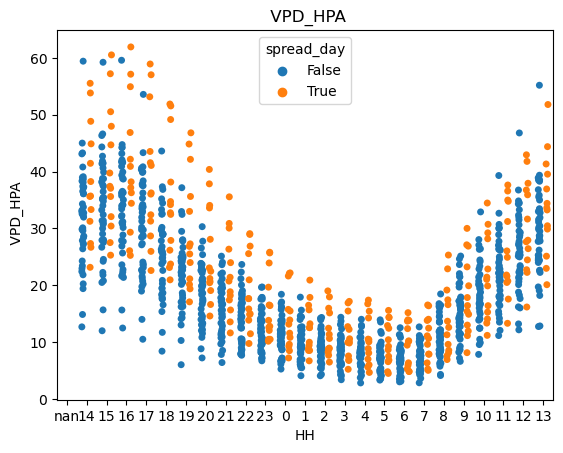

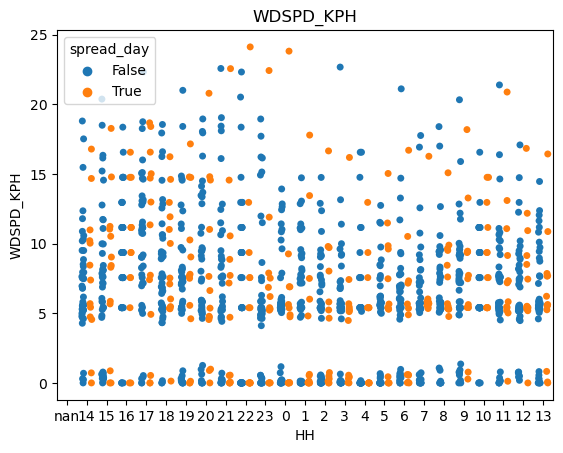

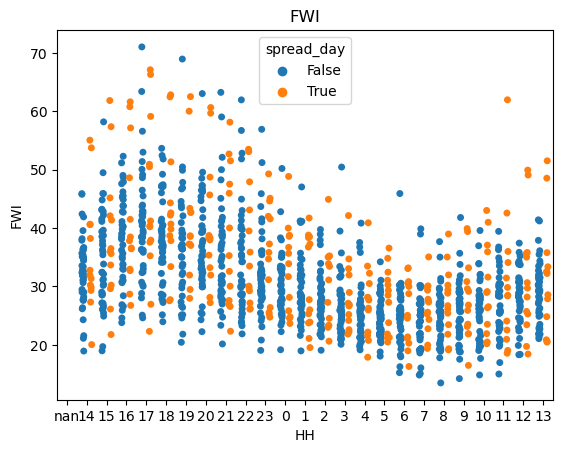

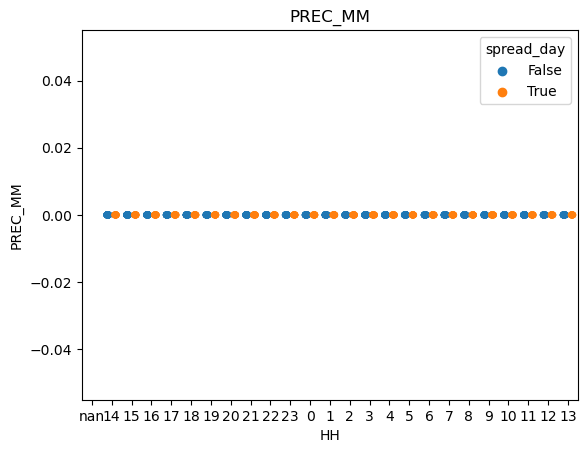

In [12]:
#full_fr["spread_day"] = (full_fr["t"] >= full_fr["t"].loc) & (full_fr["t"] <= times)
#full_fr["spread_day"].dropna()
print(full_fr.columns)

full_fr = full_fr.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
full_fr['t'] = full_fr['t'].astype('datetime64[ns]')


import seaborn as sns
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']


#for m in met:
#    plt.scatter(x = full_fr['HH'], y = full_fr[m], c = full_fr["spread_day"], s = 0.9)
#    plt.title(m)
#    plt.show()

    
# for m in met:
#    sns.violinplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"])
#    plt.title(m)
#    plt.show()  
    
# for m in met:
#     sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["is_daytime"], dodge = True)
#     plt.title(m)
#     plt.show()  

for m in met:
    sns.stripplot(x = full_fr['HH'], y = full_fr[m], hue = full_fr["spread_day"], dodge = True)
    plt.title(m)
    plt.show()

In [81]:
met = ['TEMP_C', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']  ## Station Data Columns to Plot

fire = ['flinelen',"fline_diff", "meanFRP", "sumFRP", "farea_diff", "farea" ] ## gdf columns to plot
#fire = ['flinelen']
#fire = ['meanFRP']

#full_fr  = full_fr[(full_fr["t"] >= "2020-09-01 00:00:00") & (full_fr["t"] <= "2020-09-15 00:00:00")]
full_fr  = full_fr[(full_fr["t"] <= "2020-09-25 00:00:00")]

<AxesSubplot: xlabel='t', ylabel='meanFRP'>

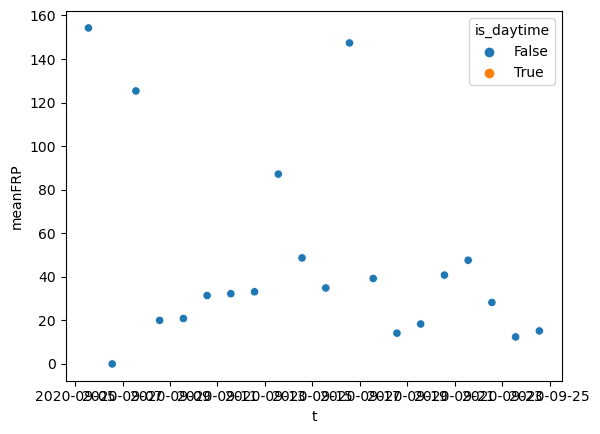

In [82]:
sns.scatterplot(x = full_fr.t, y = full_fr.meanFRP, hue = full_fr.is_daytime)

<AxesSubplot: xlabel='t', ylabel='farea'>

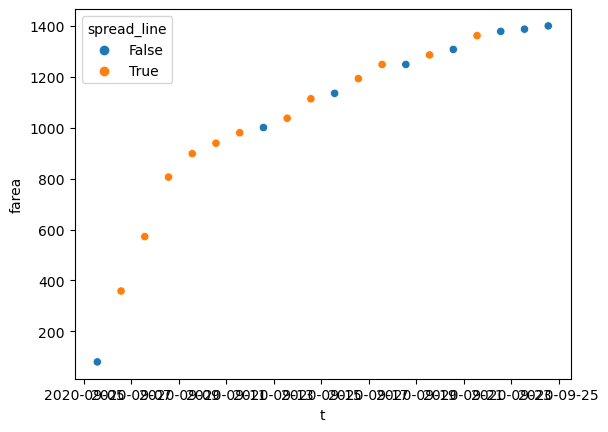

In [83]:
sns.scatterplot(x = full_fr.t, y = full_fr.farea, hue = full_fr.spread_line)

In [1]:
# example_detection = "2020-09-08 12:00:00"
# example_detection = datetime.datetime.strptime(example_detection, '%Y-%m-%d %H:%M:%S')

# example_detection2 = "2020-09-07 12:00:00"
# example_detection2 = datetime.datetime.strptime(example_detection2, '%Y-%m-%d %H:%M:%S')

# for m in met:
#     for f in fire:
#         fig, ax = plt.subplots()
        
#         #ax.scatter(full_fr["t"], full_fr[f], color = "red")
#         ax.scatter(full_fr["t"], full_fr[f], c = full_fr["spread_line"])
#         #ax.scatter(full_fr["t"], full_fr[f], c = full_fr["is_daytime"], label= )
#         #ax.legend()
#         #ax.plot(full_fr["t"], full_fr[m])
#         #plt.xticks(rotation = 90)   
#         ax.set_title(m + " vs " +  f)
#         ax.set_ylabel(f, color = "red")
#         #ax.axvline(x="2019-08-08 06:00:00", ymin=0, ymax=3000, color = "black")
#         #ax.axvline(x="2019-08-08 08:30:00", ymin=0, ymax=3000, color = "black")
#         #ax.axvline(x="2019-08-08 22:00:00", ymin=0, ymax=3000, color = "black")
#         #ax.axvline(x= example_detection, ymin=0, ymax=3000, color = "black")
#         #ax.axvline(x= example_detection2, ymin=0, ymax=3000, color = "grey")
#         #ax.axvline(x="2019-08-09 04:00:00", ymin=0, ymax=3000, color = "black")
#         ax2=ax.twinx()
#         ax2.plot(full_fr["t"],full_fr[m],color="blue",  alpha=0.3)
#         ax2.set_ylabel(m,color="blue")
#         ax.tick_params(axis='x', labelrotation = 90)
        
#         plt.show()

In [14]:
# print(full_fr.fline_diff.iloc[0:24])
# print(full_fr.flinelen.iloc[0:24])

In [2]:
#plt.scatter(full_fr.farea, full_fr.meanFRP, c = full_fr.spread_line)

In [3]:
#plt.scatter(full_fr.farea, (full_fr.meanFRP * full_fr.n_newpixels), c = full_fr.spread_line)

In [4]:
# plt.scatter(x = full_fr.farea, y = (full_fr.meanFRP * full_fr.farea), c = full_fr[" VPD_HPA"] ) # Can't calculate fraction of saturated pixels w/o going one level deeper into data
# #plt.yscale('log')
# plt.show()

In [1]:
## Look at nighttime "spread days"?

# Compare daytime w/spread vs daytime wo/spread?

In [5]:
## Compare to GEOS FRP

goes = pd.read_csv('/projects/shared-buckets/ashiklom/CALDOR_sbs/GOES17_CaldorFire.csv')
goes = gpd.GeoDataFrame(goes, 
                        geometry=gpd.points_from_xy(goes.lon, goes.lat),
                       crs='EPSG:4236')
goes.to_crs(caldor_pixels.crs,inplace=True)
goes['dt'] = pd.to_datetime(goes['date'])

NameError: name 'pd' is not defined